In [5]:
## preamble 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from cv import *
import cv2
import skimage.io
import skimage.feature
from scipy.ndimage import maximum_filter, minimum_filter

# Week 7 - Simple Image Features

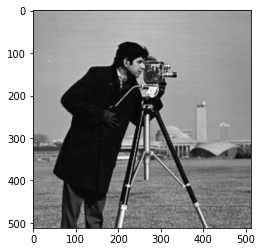

In [6]:
filename = 'cameraman.jpeg'
im = cv2.imread('/Users/s174162/OneDrive/Studie/Kandidat/1. semester/Computer vision/Week 7/'+filename)
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY).astype(np.float)/255.0
plt.imshow(im, cmap = 'gray')


## Blob detector

### Exercise 07.A

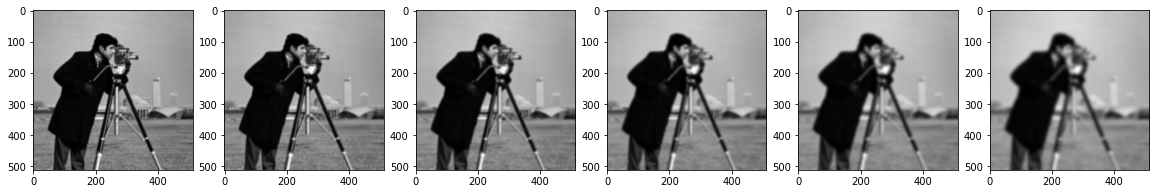

In [10]:
def getGaussDerivative(t):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Vairance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.
    ddg : numpy array
        Second order derivative of Gaussian
    dddg : numpy array
        Third order derivative of Gaussian.

    '''

    kSize = 5
    sigma = np.sqrt(t)
    x = np.arange(int(-np.ceil(sigma*kSize)), int(np.ceil(sigma*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*t))
    g = g/np.sum(g)
    dg = -x/t*g
    ddg = -g/t - x/t*dg
    dddg = -2*dg/t - x/t*ddg
    return g, dg, ddg, dddg

def scaleSpaced(im, sigma, n):
    # Im_scales = a scale space of the original image Im.
    m = 3+n
    k = 2**(1/n) # scale factor
    r,c = im.shape
    im_scales = np.zeros((r,c,m))
    tStep = np.zeros(m)

    Lg = im
    for i in range(m):
        sigma_new = sigma*k**i
        t = sigma_new**2;
        g, dg, ddg, dddg = getGaussDerivative(t)
        im_scales[:,:,i] = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)
    
    return im_scales


sigma = 1.6
n = 3
m = n+3;
k = 2*1/n

im_scales = scaleSpaced(im, sigma, n)

fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=6)
for i in range(m):
    ax[i].imshow(im_scales[:,:,i],cmap='gray')
plt.show()

### Exercise 07.B

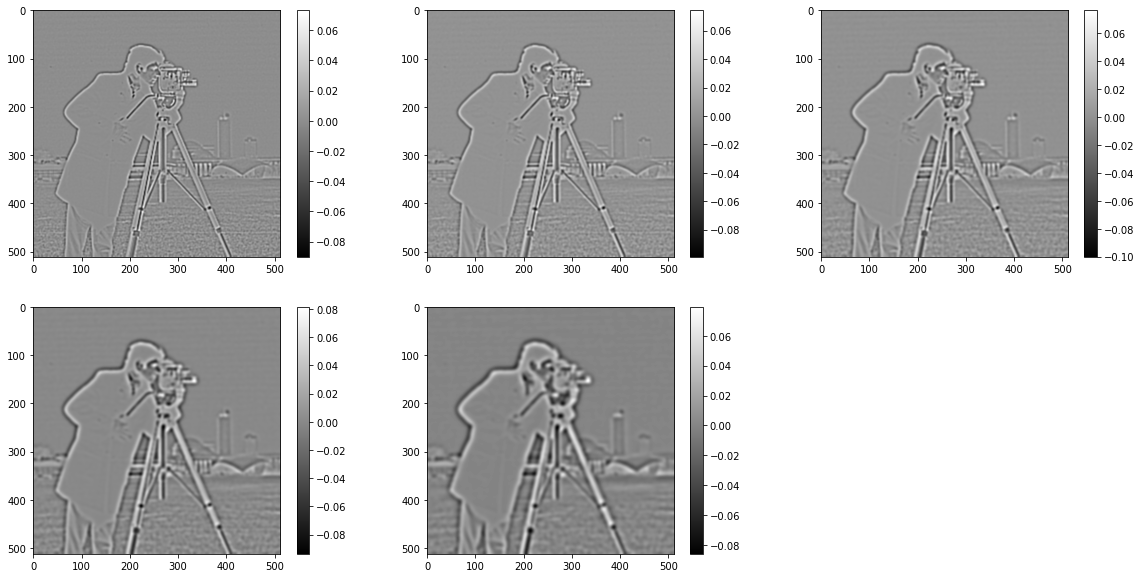

In [12]:
def differenceOfGaussian(im, sigma, n):
    # DoG = scale space difference of Gaussians of the original image im
    m = 3+n
    r,c = im.shape
    DoG = np.zeros((r,c,m-1))
    
    im_scales = scaleSpaced(im, sigma, n)
    for i in range(m-1):
        DoG[:,:,i] = im_scales[:,:,i+1]-im_scales[:,:,i]
    
    return DoG

DoG = differenceOfGaussian(im, sigma, n)

plt.figure(figsize=(20,10))
for i in range(1,DoG.shape[-1]+1):
    plt.subplot(2,3,i)
    plt.imshow(DoG[:,:,i-1], cmap = 'gray')
    plt.colorbar()

### Exercise 07.C

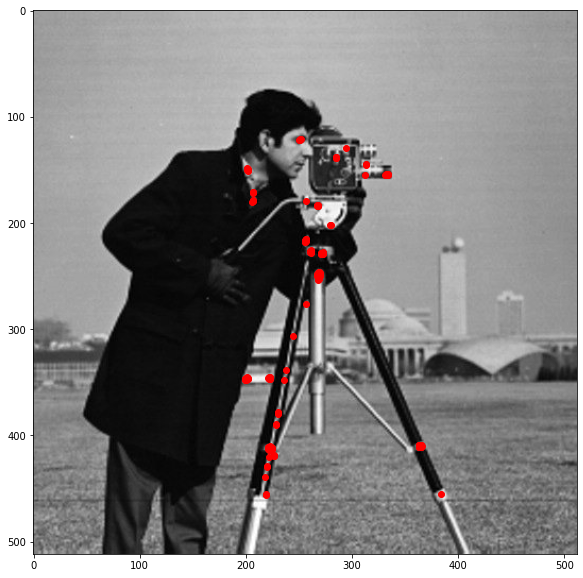

In [18]:
def detectBlobs(im, sigma, n, thres):
    # blobs = the blobs (pixels) of the original image Im with a DoG larger than a threshold.
    DoG = differenceOfGaussian(im, sigma, n)
    
    footprint = np.ones((3,3,3))
    footprint[1,1,1]=0;
    maxs = maximum_filter(np.abs(DoG), footprint=footprint)
    maxs = maxs[:,:,1:DoG.shape[-1]-1] # don't need the first and last
    
    row, col, layer = np.where(maxs > 0) # find local maximas
    vals = np.abs(DoG[col,row,layer])

    row = row[vals >= thres]
    col = col[vals >= thres]
    layer = layer[vals >= thres] # scale layer
    
    blobs = np.array([row,col,layer])
    
    return blobs
  
blobs = detectBlobs(im, sigma, n, 0.07)

plt.figure(figsize = (20,10))
plt.imshow(im,cmap='gray')

plt.plot(blobs[0,:], blobs[1,:],'ro')
plt.show()


## Using SIFT features

### Exercise 07.D

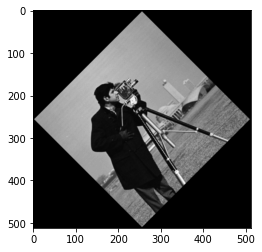

In [19]:
def transformIm(im, R, s):
    # rIm is a scaled and rotated version of the original image im.
    # R is a rotation angle
    # s is a scale factor
    r, c = im.shape
    M = cv2.getRotationMatrix2D((c / 2, r / 2), R, s) 
    rIm = cv2.warpAffine(im, M, (c, r))  
    
    return rIm

# Use this function to produce a transformed version of the test image rIm
rIm = transformIm(im, 45, 0.7);

plt.imshow(rIm, cmap='gray')

### Exercise 07.E
Use the SIFT detector to detect features in both the original and the transformed image. Plot the features on top of the images. There are quite a few parameters to play with. Try changing them and see the results.

Steps:
- Extract sift features for both images
- Now match the features to each other. Plot the matches; do they look qualitatively correct?
You can also take two photos of the same scene from different angles using e.g. a phone camera
and find matching SIFT features.

Used this procedure:
https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html?fbclid=IwAR1n1kMrUZVOcAH4tCJZWr1AvUagaViz1CusFjJ6xl_mBjv8MyaNo0NB7Z8

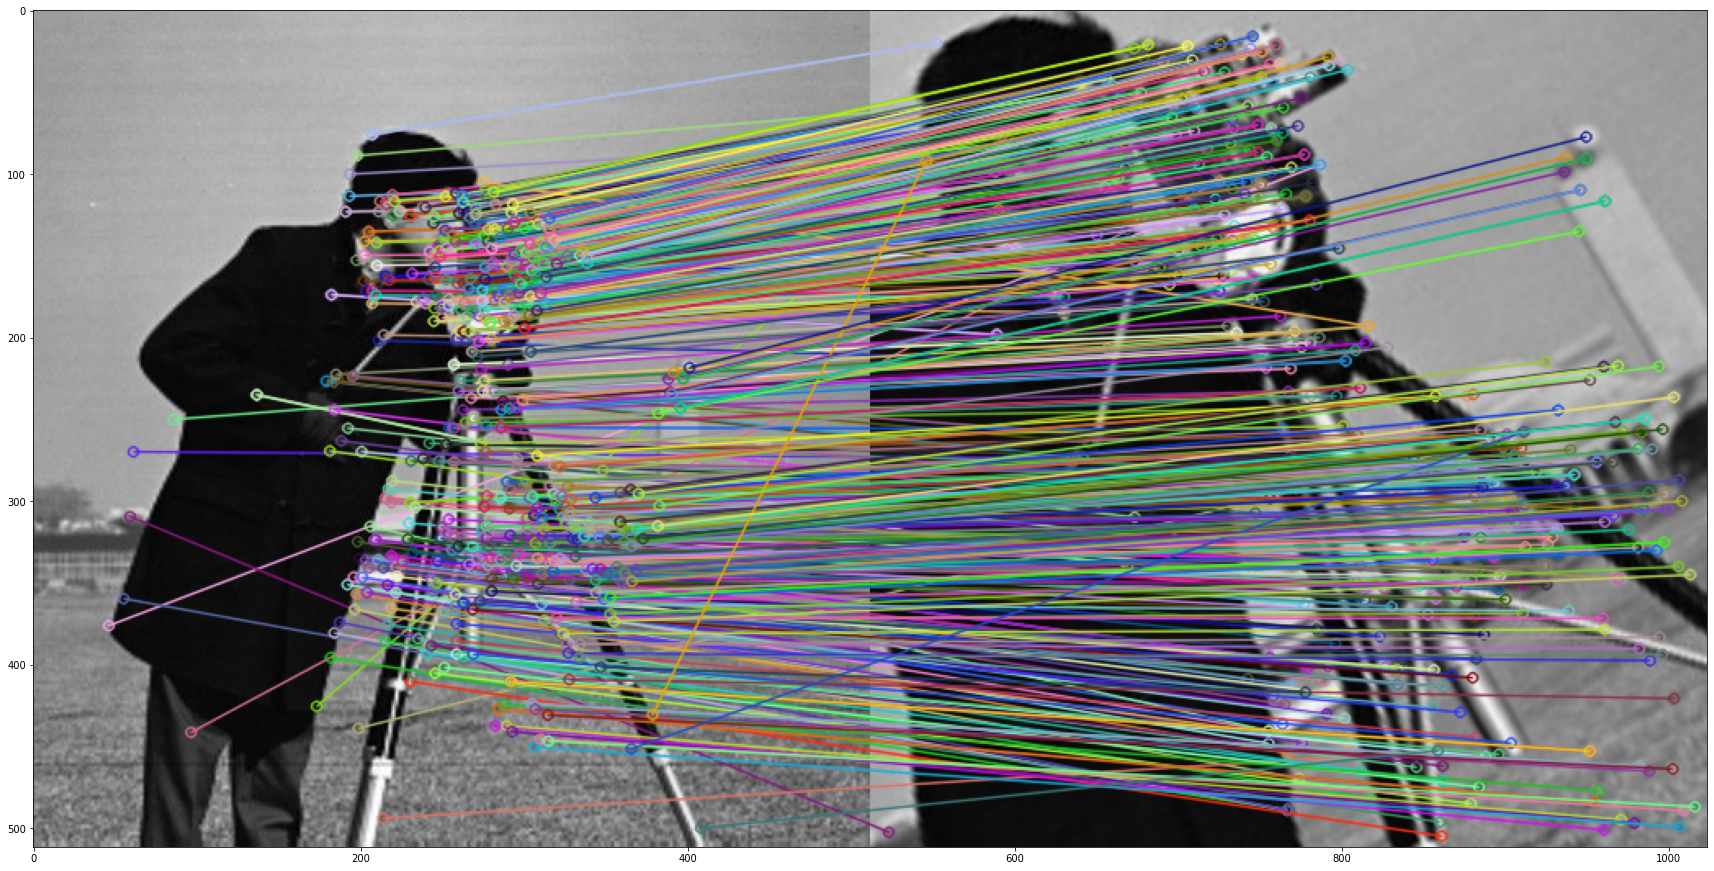

(<matplotlib.image.AxesImage at 0x7fe367763490>, None)

In [20]:
# extract sift features for both images
# take the closest distance between two points is the match 

img1 = cv2.imread('cameraman.jpeg', cv2.COLOR_BGR2GRAY)
img2 = transformIm(img1,30,1.7)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
plt.figure(figsize=(30,20))
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()